**This file takes in the aligned output which is postprocessed after being generated by the SLAM algorithm. Evaluate the aligned output with the ground truth based on certain metrics**

## Import Modules

In [1]:
import os
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import math
from matplotlib.patches import Patch
from distinctipy import get_colors # to get unique colors
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from itertools import product
from numpy.linalg import LinAlgError, eigvalsh
from scipy.spatial.transform import Rotation
from scipy.spatial import procrustes
from scipy.spatial.distance import directed_hausdorff
from scipy.spatial.distance import cdist

%matplotlib notebook

In [2]:
# BOP YCBV dataset
dataset_info = {'1': 'master_chef_can',
                '2': 'cracker_box',
                '3': 'sugar_box',
                '4': 'tomato_soup_can',
                '5': 'mustard_bottle',
                '6': 'tuna_fish_can',
                '7': 'pudding_box',
                '8': 'gelatin_box',
                '9': 'potted_meat_can',
                '10': 'banana',
                '11': 'pitcher_base',
                '12': 'bleach_cleanser',
                '13': 'bowl',
                '14': 'mug',
                '15': 'power_drill',
                '16': 'wood_block',
                '17': 'scissors',
                '18': 'large_marker',
                '19': 'large_clamp',
                '20': 'extra_large_clamp',
                '21': 'foam_brick'}

In [3]:
# folder containing the postprocessed data after aligining with the ground truth
postprocessed_file_path = "/home/allen/Desktop/RnD_Github/AllenIsaacRnD/dataset/000050/oa_slam_result/"
# folder where to export the error metrics
export_path = postprocessed_file_path

# VISUALISATION FUNCTIONS

## Function to plot ellipsoids

In [4]:
# Reference - https://github.com/qcr/quadricslam/blob/master/src/quadricslam/visualisation.py
def plot_ellipsoid(pose: np.ndarray, radii: np.ndarray, ax: matplotlib.figure.Axes, color):
    # Generate ellipsoid of appropriate size at origin
    SZ = 50
    radii = np.abs(radii)
    u, v = np.linspace(0, 2 * np.pi, SZ), np.linspace(0, np.pi, SZ)
    x, y, z = (radii[0] * np.outer(np.cos(u), np.sin(v)),
               radii[1] * np.outer(np.sin(u), np.sin(v)),
               radii[2] * np.outer(np.ones_like(u), np.cos(v)))

    # Rotate the ellipsoid, then translate to centroid
    ps = pose @ np.vstack([
        x.reshape(-1),
        y.reshape(-1),
        z.reshape(-1),
        np.ones(z.reshape(-1).shape)
    ])

    # Plot the ellipsoid
    ax.plot_wireframe(
        ps[0, :].reshape(SZ, SZ),
        ps[1, :].reshape(SZ, SZ),
        ps[2, :].reshape(SZ, SZ),
        rstride=4,
        cstride=4,
        color=color,
        linewidth=0.5,
    )

## Function to plot cuboids

In [5]:
def plot_cuboid(pose: np.ndarray, size: np.ndarray, ax: matplotlib.figure.Axes, color):
    # Get all 8 corner points of the cuboid
    #vertices = np.array(list(product(*zip(pose[:3, -1] - 0.5 * size, pose[:3, -1] + 0.5 * size))))
    vertices = np.array(list(product(*zip(- 0.5 * size, + 0.5 * size))))
    
    # Transform the cuboid's vertices using the pose matrix
    t_vertices = np.dot(pose[:3, :3], vertices.T).T + pose[:3, -1]
    
    # Define the edges of the cuboid using the vertices
    edges = [
        [t_vertices[0], t_vertices[1]], [t_vertices[1], t_vertices[5]], [t_vertices[5], t_vertices[4]],
        [t_vertices[4], t_vertices[0]], [t_vertices[7], t_vertices[6]], [t_vertices[6], t_vertices[2]],
        [t_vertices[2], t_vertices[3]], [t_vertices[3], t_vertices[7]], [t_vertices[0], t_vertices[2]],
        [t_vertices[1], t_vertices[3]], [t_vertices[4], t_vertices[6]], [t_vertices[5], t_vertices[7]]
    ]
    
    ax.add_collection3d(Line3DCollection(edges, colors=color, linewidths=2))

## Function to plot trajectory

In [6]:
def plot_traj(data: List, ax: matplotlib.figure.Axes, length = 50, c:str = 'cyan', label = None):
    
    # to plot trajectory
    traj = []
    
    for idx in range(len(data)):
        # position
#         ax.scatter(data[idx][0,-1], data[idx][1,-1], data[idx][2,-1], c='r', marker='*')
        # orientation
        if idx % 30 == 0:
            # X
            ax.quiver(data[idx][0,-1], data[idx][1,-1], data[idx][2,-1],
                      data[idx][0, 0], data[idx][1, 0], data[idx][2, 0],
                      color='b', length=length, linewidth=0.2, alpha=1)
            # Y
            ax.quiver(data[idx][0,-1], data[idx][1,-1], data[idx][2,-1],
                      data[idx][0, 1], data[idx][1, 1], data[idx][2, 1],
                      color='g', length=length, linewidth=0.2, alpha=1)
            # Z
            ax.quiver(data[idx][0,-1], data[idx][1,-1], data[idx][2,-1],
                      data[idx][0, 2], data[idx][1, 2], data[idx][2, 2],
                      color='r', length=length, linewidth=0.2, alpha=1)
        
        traj.append([data[idx][0,-1], data[idx][1,-1], data[idx][2,-1]])
        
        # for introspection
        #if idx==10:
        #    break
        
    #trajectory
    if c != 'cyan':
        traj = np.array(traj)
        if label==None:
            ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=c)
        else:
            ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=c, label = label)
        
    
    return None

## Reading the postprocessed file

In [7]:
## postprocessed_output.json
data_path = postprocessed_file_path + "aligned_output_oslam.json"

with open(data_path, 'r') as file:
    processed_data = json.load(file)

### GT and Aligned Trajectories

In [8]:
gt_traj = []

for traj in processed_data['ground_truth_camera_pose']:
    gt_traj.append(np.array(traj))

    
est_traj = []

for traj in processed_data['estimated_camera_pose']:
    est_traj.append(np.array(traj))

### GT and Aligned Object info

In [9]:
keys = list(processed_data['ground_truth_object_pose'].keys())


gt_obj = []

for o in range(len(processed_data['ground_truth_object_pose'][keys[0]])):
    temp = []
    temp.append(np.array(processed_data['ground_truth_object_pose'][keys[0]][o])) # pose
    temp.append(np.array(processed_data['ground_truth_object_pose'][keys[1]][o])) # radius
    temp.append(int(processed_data['ground_truth_object_pose'][keys[2]][o])) # label
    gt_obj.append(temp)
    

est_obj = []

for o in range(len(processed_data['estimated_object_pose'][keys[0]])):
    temp = []
    temp.append(np.array(processed_data['estimated_object_pose'][keys[0]][o])) # pose
    temp.append(np.array(processed_data['estimated_object_pose'][keys[1]][o])) # radius
    temp.append(int(processed_data['estimated_object_pose'][keys[2]][o])) # label
    est_obj.append(temp)

### Visualizing to make sure the values are correct

In [10]:
## to assign colors

classes = []

for o in range(len(gt_obj)):
    classes.append(gt_obj[o][2])
    
classes = list(set(classes))
    
colors = get_colors(len(classes))

<IPython.core.display.Javascript object>


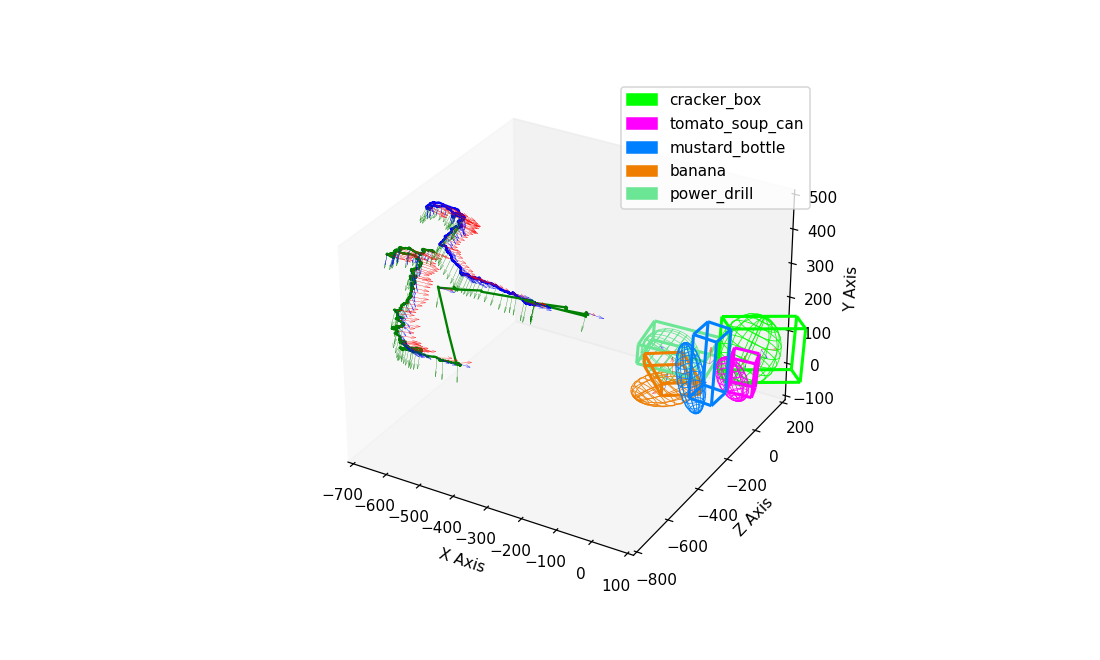

In [11]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X Axis')
ax.set_ylabel('Z Axis')
ax.set_zlabel('Y Axis')
ax.set_xlim((-700, 100))
ax.set_ylim((-800, 200))
ax.set_zlim((-100, 500))

## plotting trajectories
plot_traj(gt_traj, ax, c = 'blue', label="ground truth")
plot_traj(est_traj, ax, c = 'green', label="estimated")

# plotting GT object as cuboid and estimated object as ellipsoid
for o in range(len(gt_obj)):
    
    # plotting as pose
    plot_traj([gt_obj[o][0]], ax)
    plot_traj([est_obj[o][0]], ax)
    
    # plotting GT as cuboid
    plot_cuboid(gt_obj[o][0], (gt_obj[o][1])*2, ax, colors[classes.index(gt_obj[o][2])])
    
    # plotting est as ellipsoid
    plot_ellipsoid(est_obj[o][0], est_obj[o][1], ax, colors[classes.index(est_obj[o][2])])
 
    
ax.legend(handles=[
        Patch(facecolor=c, edgecolor=c, label=dataset_info[str(l)]) for l, c in zip(classes, colors)
    ])
ax.grid(False)
plt.show()

# ERROR METRICS

## CAMERA POSE ERRORS

### 1. Root Mean Square Error(RMSE) for Trajectory Deviation (Euclidean Distance)

In [12]:
# Given 2 centroids, it will output the euclidean distance between the 2 points
def euclidean_distance(centroid1, centroid2):
    return np.linalg.norm(centroid1 - centroid2)

In [13]:
## Euclidean distance
euc_errors = []

for i in range(len(gt_traj)):
    euc_errors.append(euclidean_distance(gt_traj[i][:3, 3], est_traj[i][:3, 3]))
    
euc_errors

[0.0,
 0.32764309850806156,
 0.2708412819346664,
 0.5500599967276742,
 0.8665719820072899,
 1.1476610998025918,
 1.5314764118326445,
 2.075698677554207,
 1.8394200172880453,
 1.7514591060027123,
 1.9983886008479663,
 2.116103967200059,
 2.3162227872118115,
 3.1857766713942666,
 1.9261318750281597,
 2.0994496897996204,
 2.3174136445614626,
 0.8144114439272191,
 1.896785174973541,
 2.0227461531293174,
 1.890930458795173,
 2.0540287242390205,
 3.376452872468239,
 3.011043008659821,
 3.58690130892938,
 4.139881761596232,
 5.396036879043625,
 5.867488133775695,
 6.961073336777734,
 7.531337862557959,
 6.046225268711064,
 5.884331907701867,
 6.370003846152642,
 6.745852503575698,
 7.1672885389105945,
 5.797252625166287,
 7.579501962530051,
 7.880085342177469,
 8.508630030739319,
 9.105549351906157,
 10.414245051850797,
 12.011716988007853,
 12.52497604788121,
 13.114147665784301,
 13.950967923409271,
 14.247938693018028,
 15.05453164332921,
 16.311245354049202,
 15.129179554754419,
 16.25732

<IPython.core.display.Javascript object>


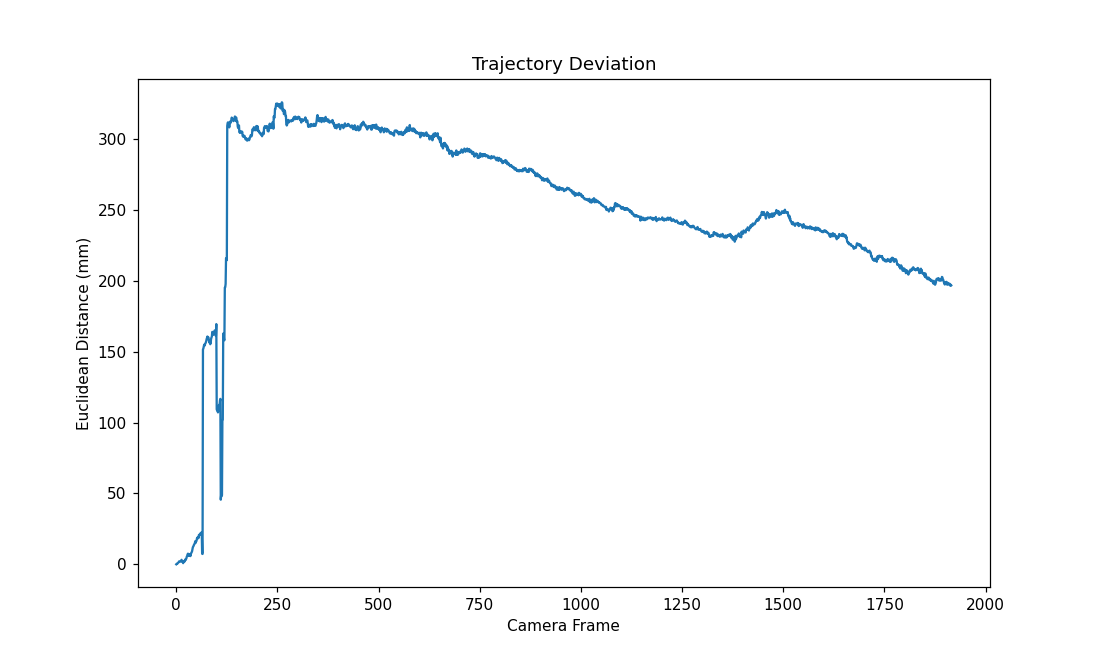

In [14]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot([i for i in range(len(euc_errors))], euc_errors)


ax.set_xlabel('Camera Frame')
ax.set_ylabel('Euclidean Distance (mm)')

plt.title("Trajectory Deviation")


plt.show()

In [15]:
min(euc_errors)

0.0

In [16]:
max(euc_errors)

326.23821109255243

In [17]:
## SE
squared_error = [item ** 2 for item in euc_errors]
squared_error

[0.0,
 0.10734999999996334,
 0.07335500000001345,
 0.302566000000049,
 0.7509470000000428,
 1.3171260000000946,
 2.3454199999997916,
 4.308525000000284,
 3.383465999999953,
 3.06760899999982,
 3.9935569999990923,
 4.477895999999828,
 5.364887999999253,
 10.149172999999932,
 3.7099839999994946,
 4.407688999999722,
 5.370405999999641,
 0.6632659999996179,
 3.597793999999406,
 4.091501999999452,
 3.575617999999323,
 4.219033999998978,
 11.400433999999022,
 9.066379999999189,
 12.865860999999299,
 17.138620999997123,
 29.117213999998864,
 34.42741699999859,
 48.4565419999979,
 56.72104999999909,
 36.55684000000018,
 34.62536199999829,
 40.57694899999945,
 45.50652599999851,
 51.37002499999917,
 33.6081379999974,
 57.448849999996895,
 62.09574500000019,
 72.39678499999899,
 82.91102899999865,
 108.4564999999988,
 144.28134499999646,
 156.87502499999803,
 171.98086899999583,
 194.6295059999944,
 203.0037570000003,
 226.63892300000046,
 266.0567249999917,
 228.89207399999913,
 264.30058799999

In [18]:
## MSE
mean_squared_error = sum(squared_error)/len(squared_error)
mean_squared_error

67417.68856055188

In [19]:
## RMSE
rmse = math.sqrt(mean_squared_error)
rmse

259.64916437483845

### 2. Average Rotation Error for Camera Poses

In [20]:
## rotation matrix to quaternion conversion
def matrix_to_quaternion(matrix):
    # Extract the 3x3 rotation matrix from the 4x4 transformation matrix
    rotation_matrix = matrix[:3, :3]

    # Ensure the rotation matrix is orthogonal (if necessary)
    if not np.allclose(np.linalg.det(rotation_matrix), 1.0):
        rotation_matrix = rotation_matrix / np.cbrt(np.linalg.det(rotation_matrix))

    # Create a Rotation object from the rotation matrix
    rotation = Rotation.from_matrix(rotation_matrix)

    # Get the quaternion representation
    quaternion = rotation.as_quat()

    return quaternion


## quaternion representation of the rotation matrix as input
def rotation_error_quaternion(quat1, quat2):
    r1 = Rotation(quat1)
    r2 = Rotation(quat2)

    # Convert to unit quaternions if necessary
    if not np.isclose(np.linalg.norm(r1.as_quat()), 1.0):
        r1 = r1.normalized()
    if not np.isclose(np.linalg.norm(r2.as_quat()), 1.0):
        r2 = r2.normalized()
    # Compute the rotation error (angle between the quaternions)
    error_angle = 2.0 * np.arccos(np.abs(np.dot(r1.as_quat(), r2.as_quat())))
    return error_angle

In [21]:
rot_errors_traj = []
    
for i in range(len(gt_traj)):
    # order is dependent
    rot_errors_traj.append(rotation_error_quaternion(matrix_to_quaternion(gt_traj[i]),
                                                     matrix_to_quaternion(est_traj[i])))
    
rot_errors_traj

[0.0,
 0.000916253924344351,
 0.0012512951291677723,
 0.0009966486312894696,
 0.001184964045677495,
 0.001701786381247904,
 0.0018330015790704386,
 0.003184636322206858,
 0.0037041281445462054,
 0.004637951438490004,
 0.006868418653918494,
 0.007350935533038223,
 0.007568702142646919,
 0.009397716206202033,
 0.0082138187240893,
 0.007444850953344589,
 0.010358557417755482,
 0.009090914900651007,
 0.00927736632530163,
 0.010365889085749085,
 0.011134618080791902,
 0.010824930139346664,
 0.013661400851285397,
 0.012766962649136442,
 0.011539715330931725,
 0.009835904530342427,
 0.010850172617025394,
 0.008087849960767725,
 0.009801153904111091,
 0.012095118729061091,
 0.012306612441955661,
 0.00978433470300479,
 0.009778136984242826,
 0.01036726610960815,
 0.01369499223498646,
 0.015169049098767482,
 0.015082222006991754,
 0.015113954655119374,
 0.015621553416162406,
 0.016597499417498034,
 0.017126007687642275,
 0.01760346984627548,
 0.017585010774509826,
 0.016336260657070903,
 0.01674

In [22]:

rot_errors_traj = [value for value in rot_errors_traj if not math.isnan(value)]

<IPython.core.display.Javascript object>


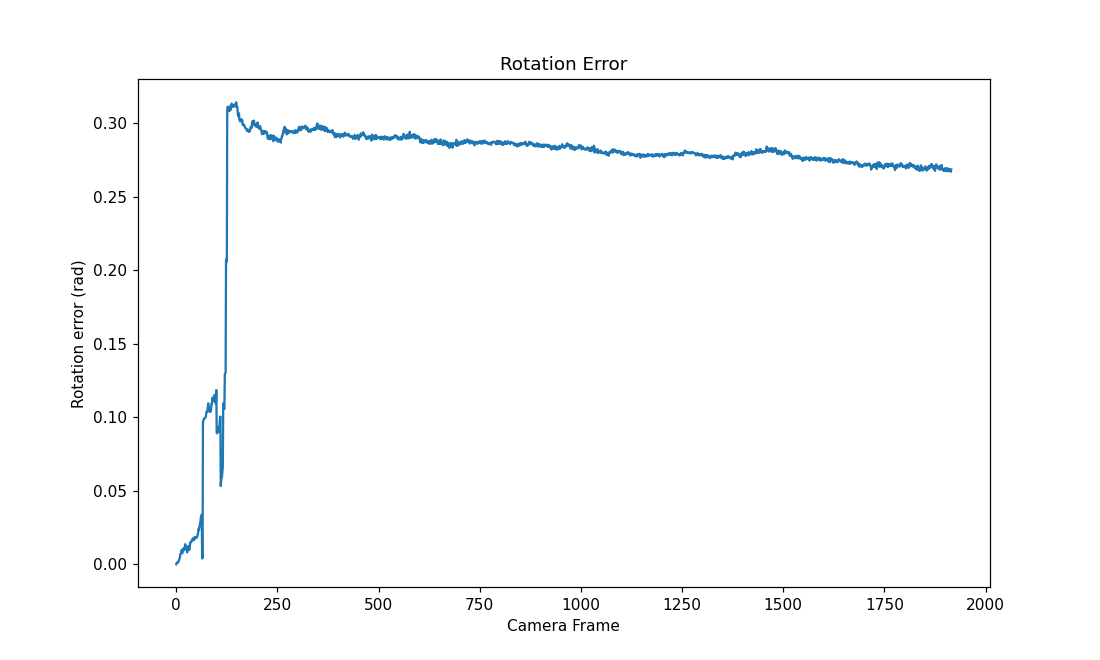

In [23]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot([i for i in range(len(rot_errors_traj))], rot_errors_traj)


ax.set_xlabel('Camera Frame')
ax.set_ylabel('Rotation error (rad)')

plt.title("Rotation Error")

# Display the plot
plt.show()

In [24]:
min(rot_errors_traj)

0.0

In [25]:
max(rot_errors_traj)

0.3144127051323103

In [26]:
avg_rot_error_traj = sum(rot_errors_traj)/len(rot_errors_traj)
avg_rot_error_traj

0.2685218789324438

### 3. Disparity Measure by Procrustes Analysis

- scipy.spatial.procrustes - aligns the second set of points with the first set after normalising them and reducing the squared error between them. Can handle scailing, rotation, reflection.
- Two sets of 3D points are passed in. Each row is each 3D point. Aligning points2 with points1.
- **Set1** is normalized version of points1
- **Set2** is normalized and aligned with set1
- **Disparity** is the dissimilarity between the points after alignment.

In [27]:
def procrustes_analysis(points1, points2):
    set1, set2, disparity = procrustes(points1, points2)
    return set1, set2, disparity

In [28]:
points_gt = []
points_est = []

for i in range(len(gt_traj)):
    points_gt.append(list(gt_traj[i][:3, 3]))
    points_est.append(list(est_traj[i][:3, 3]))
    
points_gt = np.array(points_gt)
points_est = np.array(points_est)

set1, set2, disparity = procrustes_analysis(points_gt, points_est)

In [29]:
disparity

0.06353101312487187

<IPython.core.display.Javascript object>


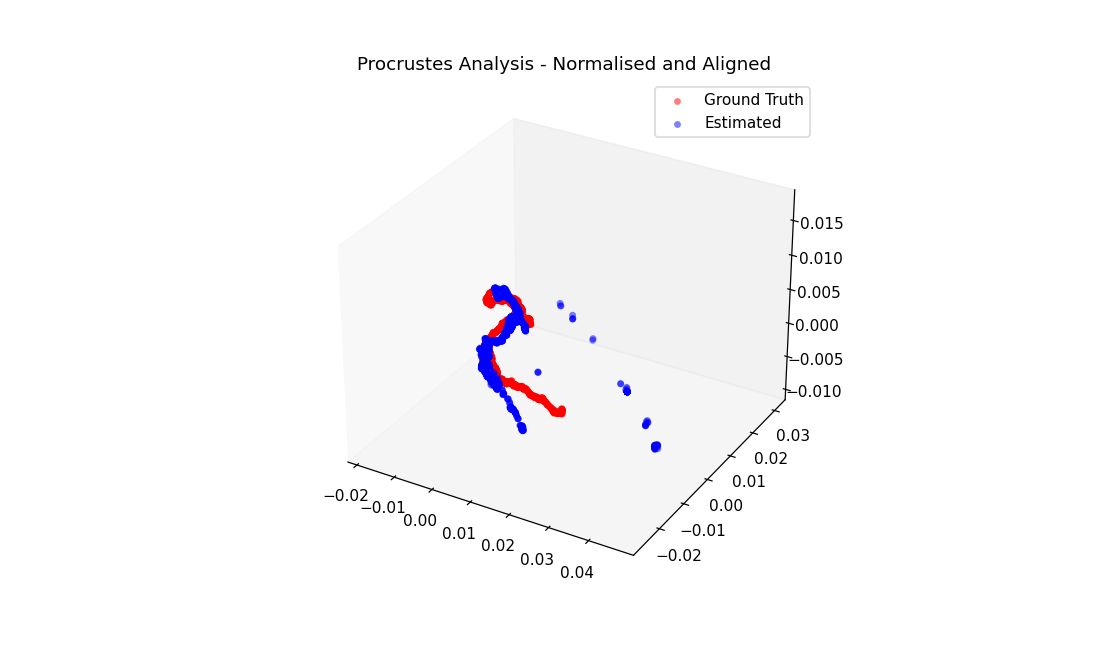

In [30]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(set1[:,0], set1[:,1], set1[:,2], c='r', marker='o', alpha=0.5, label='Ground Truth', linewidths=0.01)
ax.scatter(set2[:,0], set2[:,1], set2[:,2], c='b', marker='o', alpha=0.5, label='Estimated', linewidths=0.01)

ax.grid(False)
ax.legend()
plt.title("Procrustes Analysis - Normalised and Aligned")

# Display the plot
plt.show()

### 4. Fréchet Distance

- The Hausdorff distance between two sets of points A and B is defined as the maximum distance of a point in set A to its nearest point in set B. The directed Hausdorff distance takes into account the directionality, meaning it calculates the Hausdorff distance from one set to the other and vice versa, and then returns the maximum of the two.
- It is almost similar to max(euclidean distance)
- The two other returns values that are neglected is the index number of the point in set1 and set2 that is taken for comparison.

In [31]:
def frechet_distance(curve1, curve2):
    
    # Compute the directed Hausdorff distance (equivalent to Fréchet Distance)
    distance_1_to_2, _, _ = directed_hausdorff(curve1, curve2)
    distance_2_to_1, _, _ = directed_hausdorff(curve2, curve1)

    # Return the maximum of the two directed Hausdorff distances (Fréchet Distance)
    frechet_distance = max(distance_1_to_2, distance_2_to_1)
    return frechet_distance

In [32]:
f_dist = frechet_distance(points_gt, points_est)
f_dist

279.21587919758076

### 5. Chamfer Distance

In [33]:
def chamfer_distance(point_cloud1, point_cloud2):
    return np.mean(np.min(cdist(point_cloud1, point_cloud2),axis=0)) + np.mean(np.min(cdist(point_cloud2, point_cloud1), axis=0))

In [34]:
c_dist = chamfer_distance(points_gt, points_est)
c_dist

385.6519302294578

## OBJECT POSE ERRORS

### 1. Average Centroid Error (Euclidean Distance)

In [35]:
# GT centroids
centroids_gt = []
for o in range(len(gt_obj)):
    centroids_gt.append(gt_obj[o][0][:3,3])

# Estimated centroids
centroids_est = []
for o in range(len(est_obj)):
    centroids_est.append(est_obj[o][0][:3,3])

In [36]:
centroid_errors = []

for i in range(len(centroids_gt)):
    centroid_errors.append(euclidean_distance(centroids_gt[i], centroids_est[i]))

centroid_errors

[34.44732591814048,
 35.461650504974024,
 72.14149753134414,
 81.8485885217616,
 43.2211367446668]

In [37]:
min(centroid_errors)

34.44732591814048

In [38]:
max(centroid_errors)

81.8485885217616

In [39]:
## average centroid error
avg_cen_err = sum(centroid_errors)/len(centroid_errors)
avg_cen_err

53.424039844177415

### 2. Average Rotation Error for Object Poses

In [40]:
rot_errors_obj = []

for i in range(len(centroids_gt)):
    # order is dependent
    rot_errors_obj.append(rotation_error_quaternion(matrix_to_quaternion(gt_obj[i][0]),
                                                    matrix_to_quaternion(est_obj[i][0])))
    
rot_errors_obj

[2.739623191932247,
 0.5798358807102162,
 3.1360954083291563,
 1.5727358928165789,
 3.1030044502661354]

In [41]:
avg_rot_error_obj = sum(rot_errors_obj)/ len(rot_errors_obj)
avg_rot_error_obj

2.226258964810867

### 3. Percentage of Intersection Volume

- Generate points within the GT cuboid
- Check if they lie within the estimated ellipsoid to form the intersection percentage.
- Percentage overlap wrt GT cuboid = points within estimated ellipsoid/points within GT cuboid(all points are within cuboid by default). But the problem of this equation is that an infinitly big ellipsoid can also get 100% overlap whcih maynot be a correct metric.
- So, we compute volume of cuboid and the estimated ellipsoid.
- Equation becomes -> (2 x (volume of cuboid) x percentage_of_overlap)/(volume of cuboid + volume of estimated ellipsoid)
- so even if th eellipsoid is infinitly big, it will increase the denominator part which makes the percentage of overlap goes down.
- And when the GT cuboid is perfectly mapped by an ellipsoid, the ellipsoid's volume would be slightly bigger than the cuboid's volume. so the percentage of overlap never reaches 100%.  
- So the higher the percentage, the better is the mapped ellipsoid. Anything above 20% can be seen as good. And the percentage usually doesnt cross 80%.

In [42]:
# function to generate points within GT cuboid
def generate_points_within_cuboid(centroid, dimensions, rotation_matrix, num_points=1000):
    # Extract centroid coordinates
    cx, cy, cz = centroid
    
    # Extract dimensions of the cuboid
    Lx, Ly, Lz = dimensions
    
    # Generate random points within the unit cube
    points_in_unit_cube = np.random.rand(num_points, 3)
    
    # Scale and translate points to fit within the cuboid
    points_in_cuboid = points_in_unit_cube * np.array([Lx, Ly, Lz]) - np.array([Lx / 2, Ly / 2, Lz / 2])
    
    # Apply the rotation to the points
    rotated_points = np.dot(points_in_cuboid, rotation_matrix.T)
    
    # Translate the points to the cuboid centroid
    translated_points = rotated_points + np.array([cx, cy, cz])
    
    return translated_points

In [43]:
# function to check if the point lies within the ellipsoid
def is_point_inside_ellipsoid(point, centroid, radii, rotation_matrix):
    # Convert the point to the ellipsoid's local coordinate system
    local_point = point - centroid

    # Apply the inverse rotation to bring the point to the ellipsoid's local orientation
    local_point_rotated = np.dot(rotation_matrix.T, local_point)

    # Normalize the point by dividing its coordinates by the semi-axes lengths of the ellipsoid
    normalized_point = local_point_rotated / radii

    # Check if the normalized point lies within the unit sphere
    return np.linalg.norm(normalized_point) <= 1.0

<IPython.core.display.Javascript object>


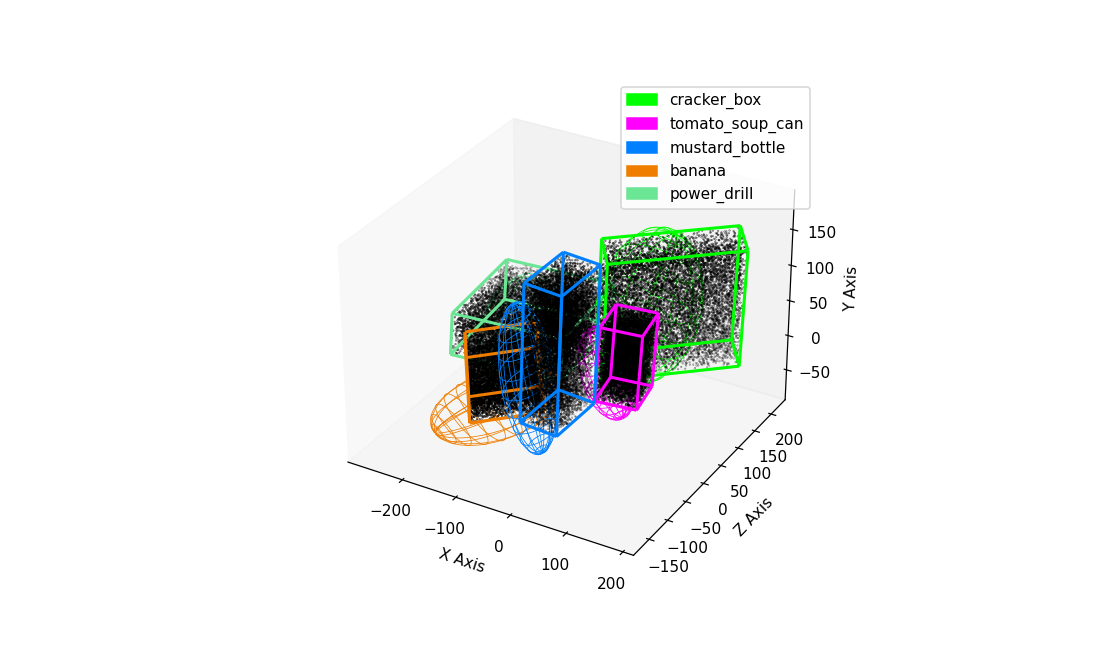

In [44]:
### For the plot ###
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X Axis')
ax.set_ylabel('Z Axis')
ax.set_zlabel('Y Axis')
ax.grid(False)
ax.legend(handles=[
    Patch(facecolor=c, edgecolor=c, label=dataset_info[str(l)]) for l, c in zip(classes, colors)
])
plt.show()


# to ensure same particles are generated for oa-slam and quadricslam
np.random.seed(50)


## The higher the nmber of points, the better is the monte-carlo approximation
num_points = 10000

overlap_cuboid = [] # percentage of overlapping points

volume_cuboid = []
volume_est_ellipsoid = []


for o in range(len(gt_obj)):
    
    # volume of a cuboid
    cube_dimensions = (gt_obj[o][1])*2
    # length * breadth * height
    volume_cuboid.append(np.prod(cube_dimensions))
    
    # volume of an ellipsoid
    volume_est_ellipsoid.append((4/3) * np.pi * (np.prod(est_obj[o][1])))
    
    # generate points within the cuboid
    points_within_cuboid = generate_points_within_cuboid(gt_obj[o][0][:3,3], cube_dimensions, 
                                                         gt_obj[o][0][:3,:3], num_points)
    points = np.array(points_within_cuboid)
    
    # check if the point is within the ellipsoid
    inside_est_ellipsoid = 0
    
    for i in range(len(points)):
        if is_point_inside_ellipsoid(points[i], est_obj[o][0][:3,3],
                                     est_obj[o][1], est_obj[o][0][:3,:3]):
            inside_est_ellipsoid+=1
            
    overlap_cuboid.append(inside_est_ellipsoid / num_points)
    
    ### Plotting the experiment ###
    # scatter the points within the plot
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='k', s=0.1)
    # plot the GT cuboid
    plot_cuboid(gt_obj[o][0], cube_dimensions, ax, colors[classes.index(gt_obj[o][2])])
    # plot the estimated ellipsoid
    plot_ellipsoid(est_obj[o][0], est_obj[o][1], ax, colors[classes.index(est_obj[o][2])])

intersection_percent = [] # percentage of intersection

for i in range(len(overlap_cuboid)):
    intersection_percent.append((2*volume_cuboid[i]*overlap_cuboid[i]*100)/(volume_cuboid[i]+volume_est_ellipsoid[i]))

In [45]:
intersection_percent

[61.648255457566826,
 40.26432100774061,
 12.272538948655813,
 0.0,
 0.0998896839836472]

In [46]:
avg_int_per = sum(intersection_percent)/len(intersection_percent)
avg_int_per

22.85700101958938

# Export data

In [47]:
labels = [dataset_info[str(l)] for l in classes]
labels

['cracker_box', 'tomato_soup_can', 'mustard_bottle', 'banana', 'power_drill']

In [48]:
export_data = {'camera_pose': {
                               'euc_error': euc_errors,
                               'root_mean_square_error': rmse,
                               'rotation_error': rot_errors_traj,
                               'average_rotation_error': avg_rot_error_traj,
                               'disparity': disparity,
                               'frechet_distance': f_dist,
                               'chamfer_distance': c_dist
                                },
               'object_pose': {
                               'centroid_error': centroid_errors,
                               'average_centroid_error': avg_cen_err,
                               'rotation_error': rot_errors_obj,
                               'average_rotation_error': avg_rot_error_obj,
                               'volume_of_intersection': intersection_percent,
                               'average_volume_of_intersection': avg_int_per,
                               'labels': labels
                                }
               }

In [49]:
with open(export_path + 'error_metrics_oaslam.json', "w") as json_file:
    json.dump(export_data, json_file, indent=4)  # indent for pretty formatting